In [2]:
%cd "../"
%pwd

import numpy as np
import matplotlib.pyplot as plt

import io 
import pandas as pd  
import pyreadr

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *
from crossValidation import *

/Users/dormann/Documents/GitHub/src


In [3]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# AE: AE3, AE4 fused

In [6]:
#Load AE3 data
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

#Load AE4 data
AE4 = pd.read_csv ('../data/merged_data/AE4.csv')
AE4 = AE4.set_index('Unnamed: 0')
y_AE4 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE4), np.shape(y_AE4))

AE = pd.concat([AE3, AE4], axis=1)
print(AE.shape)

#Fuse families info
y_AE4 += max(y_AE3) #Add the max indice of families in first dataset so that there is no overlap between families indices.
y_AE = np.hstack((y_AE3, y_AE4))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE,0.05)
AE = AE[gene_expressed]
print(AE.shape)

#Store the name of genes of interest
genes_interest = AE.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE_interest.csv', index=False)

#Create preprocess data 
AE.to_csv('../data/processed_data/AE.csv', index=False)
pd.DataFrame(y_AE).to_csv('../data/processed_data/y_AE.csv', index=False)

(32285, 333) (333,)
(32285, 1473) (1473,)
(32285, 1806)
(10470, 1806)


# Baseline with genes expressed at least in 5% of cells

In [22]:
#Load preprocess data
AE= np.array(pd.read_csv ('../data/processed_data/AE.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE.csv')))
print(np.shape(AE), np.shape(y))

(1806, 10470) (1806,)


In [23]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE,y)

In [24]:
print(AE.shape, len(pred))
acc = model.score_
print(acc, model.recovery)

(1806, 10470) 1806
0.10467179183914843 0.8809523809523809


# Mutual information maximizer (MIM)

test 0.3084351022683486 0.031083813677078125


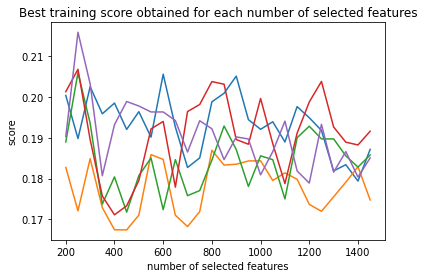

In [25]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [26]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_,model.recovery)

0.17310087173100872 0.8471760797342193


In [28]:
get_best_genes_names(subset, '../data/processed_data/AE_interest.csv', '../data/optimized_subsets/AEgenes_bestMIM.csv')

# Anova F test

test 0.26915838791286806 0.03878549489649559


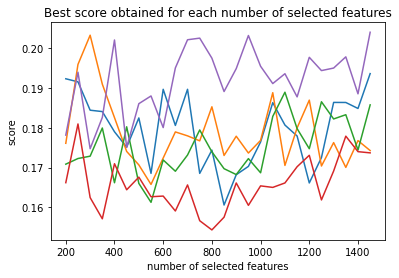

In [29]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [30]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_,model.recovery)

0.17401259301659988 0.8892580287929125


In [31]:
get_best_genes_names(subset, '../data/processed_data/AE_interest.csv', '../data/optimized_subsets/AEgenes_bestANOVA.csv')

# AE3-MEF: AE3, MEF fused

In [5]:
#Load AE3 data
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

AE3_MEF = pd.concat([AE3, D0,D6,D15], axis=1)
print(AE3_MEF.shape)

#Fuse families infos
y_D0 += max(y_AE3)
y_AE3_MEF = np.hstack((y_AE3, y_D0))

y_D6 += max(y_AE3_MEF)
y_AE3_MEF = np.hstack((y_AE3_MEF, y_D6))

y_D15 += max(y_AE3_MEF)
y_AE3_MEF = np.hstack((y_AE3_MEF, y_D15))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE3_MEF,0.05)
AE3_MEF = AE3_MEF[gene_expressed]
print(AE3_MEF.shape)

#Store the name of genes of interest
genes_interest = AE3_MEF.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE3_MEF_interest.csv', index=False)

#Create preprocess data 
AE3_MEF.to_csv('../data/processed_data/AE3_MEF.csv', index=False)
pd.DataFrame(y_AE3_MEF).to_csv('../data/processed_data/y_AE3_MEF.csv', index=False)

(32285, 333) (333,)
(32285, 461) (461,)
(32285, 154) (154,)
(32285, 178) (178,)
(32285, 1126)
(11485, 1126)


# Baseline with genes expressed at least in 5% of cells

In [9]:
#Load preprocess data
AE3_MEF = np.array(pd.read_csv ('../data/processed_data/AE3_MEF.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE3_MEF.csv')))
print(np.shape(AE3_MEF), np.shape(y))

(1126, 11485) (1126,)


In [4]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE3_MEF,y)

print(model.score_, model.recovery)

0.6370967741935484 0.6607460035523979


# Mutual information maximizer (MIM)

test 0.886272123722186 0.04383665869282783


KeyError: (slice(None, None, None), array([    0,    18,    24,    26,    35,    88,   102,   103,   107,
         111,   127,   128,   167,   189,   194,   195,   231,   237,
         251,   253,   271,   272,   279,   300,   309,   325,   339,
         363,   373,   394,   422,   435,   446,   451,   466,   481,
         508,   511,   538,   542,   544,   569,   572,   586,   594,
         617,   661,   664,   677,   712,   753,   765,   787,   807,
         818,   838,   845,   847,   851,   858,   864,   882,   899,
         917,   939,   947,   992,   996,  1032,  1057,  1082,  1096,
        1107,  1177,  1187,  1188,  1211,  1252,  1256,  1279,  1280,
        1300,  1318,  1324,  1330,  1332,  1355,  1358,  1384,  1414,
        1415,  1428,  1434,  1467,  1474,  1493,  1495,  1520,  1550,
        1553,  1559,  1567,  1584,  1600,  1602,  1605,  1607,  1613,
        1636,  1653,  1658,  1665,  1676,  1714,  1728,  1741,  1742,
        1755,  1770,  1787,  1801,  1804,  1815,  1817,  1818,  1821,
        1822,  1845,  1853,  1872,  1913,  1931,  1940,  1950,  1959,
        1974,  1990,  1998,  2012,  2025,  2032,  2048,  2054,  2060,
        2071,  2080,  2101,  2110,  2113,  2128,  2193,  2216,  2226,
        2235,  2263,  2275,  2284,  2293,  2299,  2321,  2340,  2346,
        2347,  2369,  2405,  2449,  2451,  2462,  2478,  2485,  2515,
        2526,  2547,  2577,  2579,  2584,  2630,  2635,  2637,  2661,
        2662,  2664,  2672,  2687,  2697,  2721,  2728,  2734,  2744,
        2745,  2783,  2801,  2860,  2861,  2890,  2893,  2929,  2959,
        2987,  3010,  3012,  3020,  3023,  3051,  3096,  3101,  3108,
        3121,  3135,  3141,  3162,  3180,  3233,  3252,  3256,  3261,
        3274,  3292,  3311,  3361,  3369,  3377,  3416,  3434,  3443,
        3445,  3501,  3502,  3510,  3528,  3557,  3572,  3581,  3584,
        3587,  3591,  3602,  3607,  3610,  3622,  3624,  3635,  3643,
        3647,  3668,  3680,  3686,  3701,  3702,  3713,  3737,  3738,
        3749,  3756,  3780,  3786,  3792,  3795,  3831,  3832,  3837,
        3845,  3853,  3875,  3880,  3886,  3898,  3944,  3952,  3955,
        3986,  3988,  3989,  3996,  3997,  4003,  4007,  4016,  4022,
        4028,  4037,  4059,  4062,  4065,  4066,  4078,  4084,  4107,
        4126,  4138,  4141,  4142,  4169,  4178,  4179,  4180,  4182,
        4235,  4236,  4248,  4256,  4276,  4309,  4314,  4333,  4341,
        4342,  4377,  4384,  4388,  4459,  4461,  4462,  4471,  4478,
        4483,  4490,  4497,  4527,  4546,  4562,  4580,  4614,  4621,
        4622,  4650,  4656,  4658,  4667,  4696,  4703,  4707,  4713,
        4724,  4734,  4738,  4739,  4746,  4752,  4753,  4795,  4825,
        4826,  4829,  4860,  4898,  4909,  4910,  4926,  4927,  4928,
        4944,  4948,  4954,  4955,  4957,  4958,  4978,  4980,  5023,
        5024,  5046,  5049,  5076,  5091,  5094,  5102,  5103,  5104,
        5127,  5128,  5129,  5133,  5161,  5163,  5173,  5177,  5213,
        5233,  5260,  5265,  5278,  5279,  5283,  5291,  5292,  5294,
        5295,  5308,  5329,  5334,  5338,  5344,  5380,  5383,  5388,
        5389,  5397,  5407,  5413,  5444,  5468,  5475,  5479,  5514,
        5517,  5533,  5549,  5553,  5562,  5575,  5600,  5615,  5618,
        5619,  5695,  5758,  5760,  5767,  5777,  5801,  5805,  5816,
        5827,  5849,  5874,  5887,  5899,  5905,  5922,  5941,  5950,
        5952,  5958,  6000,  6001,  6002,  6006,  6008,  6009,  6061,
        6067,  6085,  6087,  6107,  6111,  6187,  6199,  6209,  6227,
        6230,  6264,  6295,  6300,  6302,  6317,  6323,  6327,  6357,
        6381,  6388,  6406,  6422,  6445,  6460,  6479,  6482,  6485,
        6494,  6535,  6538,  6551,  6583,  6621,  6633,  6634,  6669,
        6692,  6704,  6719,  6737,  6752,  6758,  6776,  6780,  6783,
        6792,  6795,  6805,  6824,  6842,  6851,  6852,  6861,  6864,
        6865,  6866,  6906,  6913,  6914,  6932,  6958,  6984,  6998,
        7014,  7017,  7020,  7092,  7093,  7115,  7132,  7138,  7141,
        7154,  7170,  7175,  7184,  7237,  7260,  7261,  7283,  7321,
        7369,  7381,  7393,  7396,  7407,  7432,  7437,  7456,  7457,
        7460,  7462,  7466,  7479,  7498,  7500,  7574,  7575,  7594,
        7606,  7607,  7611,  7622,  7654,  7656,  7661,  7684,  7695,
        7696,  7749,  7755,  7775,  7790,  7793,  7795,  7873,  7877,
        7879,  7898,  7932,  7939,  7948,  7956,  7985,  8033,  8040,
        8075,  8076,  8077,  8082,  8096,  8105,  8107,  8109,  8118,
        8119,  8155,  8158,  8178,  8199,  8207,  8214,  8227,  8233,
        8293,  8299,  8301,  8330,  8358,  8386,  8427,  8447,  8455,
        8460,  8465,  8497,  8502,  8509,  8550,  8560,  8593,  8598,
        8620,  8623,  8625,  8630,  8658,  8676,  8682,  8685,  8716,
        8733,  8743,  8744,  8761,  8766,  8819,  8840,  8843,  8857,
        8861,  8902,  8907,  8937,  8940,  8987,  8993,  9005,  9006,
        9013,  9020,  9029,  9035,  9040,  9052,  9059,  9063,  9099,
        9100,  9128,  9129,  9147,  9180,  9184,  9197,  9200,  9223,
        9224,  9235,  9247,  9251,  9268,  9299,  9354,  9355,  9357,
        9416,  9427,  9430,  9447,  9472,  9485,  9543,  9593,  9628,
        9634,  9638,  9654,  9655,  9659,  9680,  9685,  9689,  9691,
        9699,  9703,  9713,  9717,  9732,  9743,  9746,  9777,  9837,
        9841,  9844,  9890,  9891,  9922,  9971,  9989, 10000, 10002,
       10012, 10014, 10028, 10029, 10039, 10071, 10085, 10107, 10111,
       10113, 10125, 10133, 10137, 10155, 10158, 10159, 10174, 10179,
       10262, 10310, 10311, 10325, 10331, 10346, 10352, 10364, 10383,
       10416, 10432, 10465, 10475, 10504, 10511, 10518, 10560, 10575,
       10580, 10582, 10615, 10626, 10642, 10675, 10676, 10729, 10744,
       10746, 10761, 10762, 10771, 10788, 10789, 10805, 10839, 10842,
       10855, 10878, 10880, 10887, 10928, 10933, 10946, 10954, 10978,
       10988, 11035, 11098, 11131, 11147, 11183, 11198, 11206, 11223,
       11232, 11236, 11238, 11251, 11259, 11263, 11276, 11284, 11305,
       11310, 11321, 11323, 11331, 11336, 11343, 11357, 11358, 11360,
       11362, 11374, 11382, 11393, 11424, 11456, 11461, 11468, 11469,
       11470, 11471, 11472, 11473, 11476, 11477, 11478, 11481],
      dtype=int64))

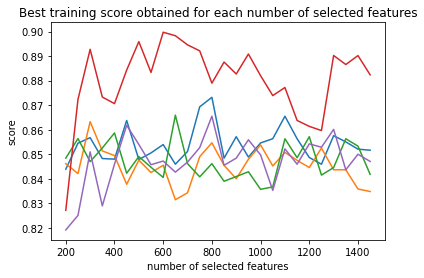

In [5]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE3_MEF, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [14]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE3_MEF[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_,model.recovery)

0.8454332552693209 0.7584369449378331


In [7]:
get_best_genes_names(subset, '../data/processed_data/AE3_MEF_interest.csv', '../data/optimized_subsets/AE3_MEFgenes_bestMIM.csv')

# Anova F test

test 0.9040715061648485 0.03770856434182588


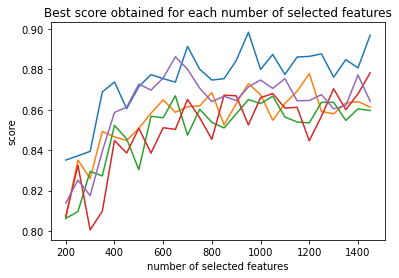

In [18]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE3_MEF, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [19]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE3_MEF[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_,model.recovery)

0.857451403887689 0.822380106571936


In [21]:
get_best_genes_names(subset, '../data/processed_data/AE3_MEF_interest.csv', '../data/optimized_subsets/AE3_MEFgenes_bestANOVA.csv')

# AE4-MEF: AE4, MEF fused

In [3]:
#Load AE3 data
AE4 = pd.read_csv ('../data/merged_data/AE4.csv')
AE4 = AE4.set_index('Unnamed: 0')
y_AE4 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE4), np.shape(y_AE4))

#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

AE4_MEF = pd.concat([AE4, D0,D6,D15], axis=1)
print(AE4_MEF.shape)

#Fuse families infos
y_D0 += max(y_AE4)
y_AE4_MEF = np.hstack((y_AE4, y_D0))

y_D6 += max(y_AE4_MEF)
y_AE4_MEF = np.hstack((y_AE4_MEF, y_D6))

y_D15 += max(y_AE4_MEF)
y_AE4_MEF = np.hstack((y_AE4_MEF, y_D15))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE4_MEF,0.05)
AE4_MEF = AE4_MEF[gene_expressed]
print(AE4_MEF.shape)

#Store the name of genes of interest
genes_interest = AE4_MEF.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE4_MEF_interest.csv', index=False)

#Create preprocess data 
AE4_MEF.to_csv('../data/processed_data/AE4_MEF.csv', index=False)
pd.DataFrame(y_AE4_MEF).to_csv('../data/processed_data/y_AE4_MEF.csv', index=False)

(32285, 1473) (1473,)
(32285, 461) (461,)
(32285, 154) (154,)
(32285, 178) (178,)
(32285, 2266)
(10625, 2266)


# Baseline with genes expressed at least in 5% of cells

In [4]:
#Load preprocess data
AE4_MEF = np.array(pd.read_csv ('../data/processed_data/AE4_MEF.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE4_MEF.csv')))
print(np.shape(AE4_MEF), np.shape(y))

(2266, 10625) (2266,)


In [5]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE4_MEF,y)

print(model.score_, model.recovery)

0.18370073480293922 0.8592233009708737


# Mutual information maximizer (MIM)

test 0.3421161903039584 0.028330524625542416


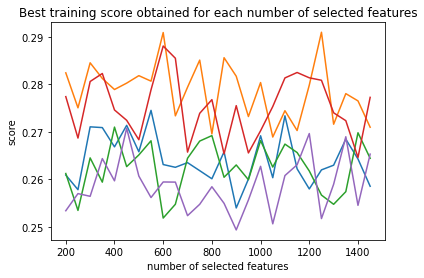

In [6]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE4_MEF, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [7]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE4_MEF[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.26941255908170153 0.9152691968225949


In [8]:
get_best_genes_names(subset, '../data/processed_data/AE4_MEF_interest.csv', '../data/optimized_subsets/AE4_MEFgenes_bestMIM.csv')

# Anova F test

test 0.30031492687857886 0.014567535882473916


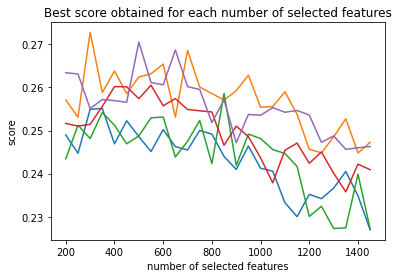

In [9]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE4_MEF, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [10]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE4_MEF[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.24347258485639686 0.9298323036187114


In [11]:
get_best_genes_names(subset, '../data/processed_data/AE4_MEF_interest.csv', '../data/optimized_subsets/AE4_MEFgenes_bestANOVA.csv')

# AE-MEF: AE3, AE4, MEF fused

In [12]:
#Load AE3 data
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

#Load AE4 data
AE4 = pd.read_csv ('../data/merged_data/AE4.csv')
AE4 = AE4.set_index('Unnamed: 0')
y_AE4 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE4), np.shape(y_AE4))

#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

AE_MEF = pd.concat([AE3, AE4, D0 ,D6, D15], axis=1)
print(AE_MEF.shape)

#Fuse families infos
y_AE4 += max(y_AE3) #Add the max indice of families in first dataset so that there is no overlap between families indices.
y_AE_MEF = np.hstack((y_AE3, y_AE4))

y_D0 += max(y_AE_MEF)
y_AE_MEF = np.hstack((y_AE_MEF, y_D0))

y_D6 += max(y_AE_MEF)
y_AE_MEF = np.hstack((y_AE_MEF, y_D6))

y_D15 += max(y_AE_MEF)
y_AE_MEF = np.hstack((y_AE_MEF, y_D15))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE_MEF,0.05)
AE_MEF = AE_MEF[gene_expressed]
print(AE_MEF.shape)

#Store the name of genes of interest
genes_interest = AE_MEF.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE_MEF_interest.csv', index=False)

#Create preprocess data 
AE_MEF.to_csv('../data/processed_data/AE_MEF.csv', index=False)
pd.DataFrame(y_AE_MEF).to_csv('../data/processed_data/y_AE_MEF.csv', index=False)

(32285, 333) (333,)
(32285, 1473) (1473,)
(32285, 461) (461,)
(32285, 154) (154,)
(32285, 178) (178,)
(32285, 2599)
(10955, 2599)


# Baseline with genes expressed at least in 5% of cells

In [13]:
#Load preprocess data
AE_MEF = np.array(pd.read_csv ('../data/processed_data/AE_MEF.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE_MEF.csv')))
print(np.shape(AE_MEF), np.shape(y))

(2599, 10955) (2599,)


In [14]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE_MEF,y)

print(model.score_, model.recovery)

0.2085889570552147 0.8214697960754136


# Mutual information maximizer (MIM)

test 0.42760191301482264 0.03367973736042708


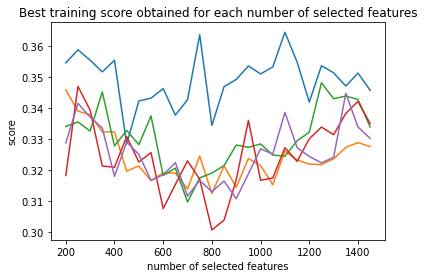

In [15]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_MEF, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [16]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_MEF[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.3337222870478413 0.9045786841092728


In [17]:
get_best_genes_names(subset, '../data/processed_data/AE_MEF_interest.csv', '../data/optimized_subsets/AE_MEFgenes_bestMIM.csv')

# Anova F test

test 0.3516812551550044 0.02070823104536013


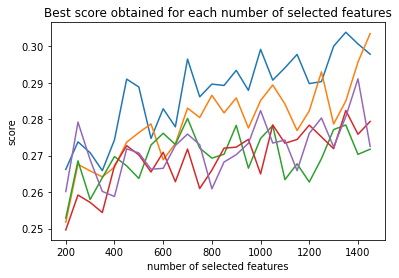

In [18]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_MEF, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [19]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_MEF[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.26686567164179104 0.8826471719892266


In [20]:
get_best_genes_names(subset, '../data/processed_data/AE_MEF_interest.csv', '../data/optimized_subsets/AE_MEFgenes_bestANOVA.csv')

# AE3-LK: AE3, LK fused

In [46]:
#Load AE3 data
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

#Load Weinreb LK data
LK = pd.read_csv ('../data/merged_data/LK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LK.csv')))
print(np.shape(LK), np.shape(y_LK))

#Drop genes not present in AE3
LK = LK.loc[AE3.index.intersection(LK.index)]
AE3 = AE3.loc[LK.index]
print(np.shape(AE3), np.shape(y_AE3))

#Get name of genes that are repeated in Weinreb data
genes, counts_gene = np.unique(LK.index, return_counts=True)
ind = np.where(counts_gene>1) #get indices of genes appearing more than once
non_unique_genes = genes[ind]

non_unique_genes= list(np.unique(non_unique_genes))

#Remove this genes from all data set
AE3 = AE3.drop(index= non_unique_genes)
LK = LK.drop(non_unique_genes)

AE_LK = pd.concat([AE3, LK], axis=1)
print(AE_LK.shape)

#Fuse families infos
y_LK += max(y_AE3) #Add the max indice of families in first dataset so that there is no overlap between families indices.
y_AE_LK = np.hstack((y_AE3, y_LK))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE_LK,0.05)
AE_LK = AE_LK[gene_expressed]
print(AE_LK.shape)

#Store the name of genes of interest
genes_interest = AE_LK.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE3_LK_interest.csv', index=False)

#Create preprocess data 
AE_LK.to_csv('../data/processed_data/AE3_LK.csv', index=False)
pd.DataFrame(y_AE_LK).to_csv('../data/processed_data/y_AE3_LK.csv', index=False)

(32285, 333) (333,)
(16760, 610) (610,)
(16410, 333) (333,)
(16182, 943)
(10246, 943)


# Baseline with genes expressed at least in 5% of cells

In [55]:
#Load preprocess data
AE_LK = np.array(pd.read_csv ('../data/processed_data/AE3_LK.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE3_LK.csv')))
print(np.shape(AE_LK), np.shape(y))

(943, 10246) (943,)


In [56]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE_LK,y)

print(model.score_, model.recovery)

0.2618629173989455 0.7550371155885471


# Mutual information maximizer (MIM)

test 0.4169767452526073 0.06564367395602635


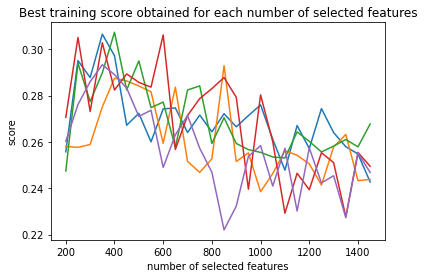

In [57]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [58]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.2987910189982729 0.8080593849416755


In [59]:
get_best_genes_names(subset, '../data/processed_data/AE3_LK_interest.csv', '../data/optimized_subsets/AE3_LKgenes_bestMIM.csv')

# Anova F test

test 0.40067618348161566 0.06288237125780397


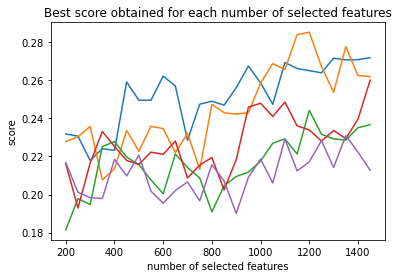

In [60]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [61]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.23156089193825044 0.7974549310710498


In [62]:
get_best_genes_names(subset, '../data/processed_data/AE3_LK_interest.csv', '../data/optimized_subsets/AE3_LKgenes_bestANOVA.csv')

# AE4-LK: AE4, LK fused

In [50]:
#Load AE3 data
AE4 = pd.read_csv ('../data/merged_data/AE4.csv')
AE4 = AE4.set_index('Unnamed: 0')
y_AE4 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE4), np.shape(y_AE4))

#Load Weinreb LK data
LK = pd.read_csv ('../data/merged_data/LK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LK.csv')))
print(np.shape(LK), np.shape(y_LK))

#Drop genes not present in AE3
LK = LK.loc[AE4.index.intersection(LK.index)]
AE4 = AE4.loc[LK.index]

#Get name of genes that are repeated in Weinreb data
genes, counts_gene = np.unique(LK.index, return_counts=True)
ind = np.where(counts_gene>1) #get indices of genes appearing more than once
non_unique_genes = genes[ind]

non_unique_genes= list(np.unique(non_unique_genes))

#Remove this genes from all data set
AE4 = AE4.drop(index= non_unique_genes)
LK = LK.drop(non_unique_genes)

AE_LK = pd.concat([AE4, LK], axis=1)
print(AE_LK.shape)

#Fuse families infos
y_LK += max(y_AE4) #Add the max indice of families in first dataset so that there is no overlap between families indices.
y_AE_LK = np.hstack((y_AE4, y_LK))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE_LK,0.05)
AE_LK = AE_LK[gene_expressed]
print(AE_LK.shape)

#Store the name of genes of interest
genes_interest = AE_LK.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE4_LK_interest.csv', index=False)

#Create preprocess data 
AE_LK.to_csv('../data/processed_data/AE4_LK.csv', index=False)
pd.DataFrame(y_AE_LK).to_csv('../data/processed_data/y_AE4_LK.csv', index=False)

(32285, 1473) (1473,)
(16760, 610) (610,)
(16182, 2083)
(9359, 2083)


# Baseline with genes expressed at least in 5% of cells

In [63]:
#Load preprocess data
AE_LK = np.array(pd.read_csv ('../data/processed_data/AE4_LK.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE4_LK.csv')))
print(np.shape(AE_LK), np.shape(y))

(2083, 9359) (2083,)


In [64]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE_LK,y)

print(model.score_, model.recovery)

0.07763221737020863 0.9011041766682669


# Mutual information maximizer (MIM)

In [ ]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [ ]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

In [ ]:
get_best_genes_names(subset, '../data/processed_data/AE4_LK_interest.csv', '../data/optimized_subsets/AE4_LKgenes_bestMIM.csv')

# Anova F test

In [ ]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [ ]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

In [ ]:
get_best_genes_names(subset, '../data/processed_data/AE4_LK_interest.csv', '../data/optimized_subsets/AE4_LKgenes_bestANOVA.csv')

# MEF-LK: MEF, LK fused

In [51]:
#Load Weinreb LK data
LK = pd.read_csv ('../data/merged_data/LK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LK.csv')))
print(np.shape(LK), np.shape(y_LK))

#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

MEF = pd.concat([D0 ,D6, D15], axis=1)

#Drop genes not present in AE3
LK = LK.loc[MEF.index.intersection(LK.index)]
MEF = MEF.loc[LK.index]

#Get name of genes that are repeated in Weinreb data
genes, counts_gene = np.unique(LK.index, return_counts=True)
ind = np.where(counts_gene>1) #get indices of genes appearing more than once
non_unique_genes = genes[ind]

non_unique_genes= list(np.unique(non_unique_genes))

#Remove this genes from all data set
MEF = MEF.drop(index= non_unique_genes)
LK = LK.drop(non_unique_genes)


LK_MEF = pd.concat([LK, MEF], axis=1)
print(LK_MEF.shape)

y_D0 += max(y_LK)
y_LK_MEF = np.hstack((y_LK, y_D0))

y_D6 += max(y_LK_MEF)
y_LK_MEF = np.hstack((y_LK_MEF, y_D6))

y_D15 += max(y_LK_MEF)
y_LK_MEF = np.hstack((y_LK_MEF, y_D15))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(LK_MEF,0.05)
LK_MEF = LK_MEF[gene_expressed]
print(LK_MEF.shape)

#Store the name of genes of interest
genes_interest = LK_MEF.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/MEF_LK_interest.csv', index=False)

#Create preprocess data 
LK_MEF.to_csv('../data/processed_data/MEF_LK.csv', index=False)
pd.DataFrame(y_LK_MEF).to_csv('../data/processed_data/y_MEF_LK.csv', index=False)

(16760, 610) (610,)
(32285, 461) (461,)
(32285, 154) (154,)
(32285, 178) (178,)
(16182, 1403)
(9686, 1403)


# Baseline with genes expressed at least in 5% of cells

In [ ]:
#Load preprocess data
AE_LK = np.array(pd.read_csv ('../data/processed_data/MEF_LK.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_MEF_LK.csv')))
print(np.shape(AE_LK), np.shape(y))

In [ ]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE_LK,y)

print(model.score_, model.recovery)

# Mutual information maximizer (MIM)

In [ ]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [ ]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

In [ ]:
get_best_genes_names(subset, '../data/processed_data/MEF_LK_interest.csv', '../data/optimized_subsets/MEF_LKgenes_bestMIM.csv')

# Anova F test

In [ ]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [ ]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

In [ ]:
get_best_genes_names(subset, '../data/processed_data/MEF_LK_interest.csv', '../data/optimized_subsets/MEF_LKgenes_bestANOVA.csv')

# AE3-LSK: AE3, LSK fused

In [52]:
#Load AE3 data
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

#Load Weinreb LK data
LK = pd.read_csv ('../data/merged_data/LSK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LSK.csv')))
print(np.shape(LK), np.shape(y_LK))

#Drop genes not present in AE3
LK = LK.loc[AE3.index.intersection(LK.index)]
AE3 = AE3.loc[LK.index]

#Get name of genes that are repeated in Weinreb data
genes, counts_gene = np.unique(LK.index, return_counts=True)
ind = np.where(counts_gene>1) #get indices of genes appearing more than once
non_unique_genes = genes[ind]

non_unique_genes= list(np.unique(non_unique_genes))

#Remove this genes from all data set
AE3 = AE3.drop(index= AE3.index.intersection(non_unique_genes))
LK = LK.loc[AE3.index]

AE_LK = pd.concat([AE3, LK], axis=1)
print(AE_LK.shape)

#Fuse families infos
y_LK += max(y_AE3) #Add the max indice of families in first dataset so that there is no overlap between families indices.
y_AE_LK = np.hstack((y_AE3, y_LK))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE_LK,0.05)
AE_LK = AE_LK[gene_expressed]
print(AE_LK.shape)

#Store the name of genes of interest
genes_interest = AE_LK.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE3_LSK_interest.csv', index=False)

#Create preprocess data 
AE_LK.to_csv('../data/processed_data/AE3_LSK.csv', index=False)
pd.DataFrame(y_AE_LK).to_csv('../data/processed_data/y_AE3_LSK.csv', index=False)

(32285, 333) (333,)
(25289, 3383) (3383,)
(24176, 3716)
(8781, 3716)


# Baseline with genes expressed at least in 5% of cells

In [ ]:
#Load preprocess data
AE_LK = np.array(pd.read_csv ('../data/processed_data/AE3_LSK.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE3_LSK.csv')))
print(np.shape(AE_LK), np.shape(y))

In [ ]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE_LK,y)

print(model.score_, model.recovery)

# Mutual information maximizer (MIM)

In [ ]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [ ]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

In [ ]:
get_best_genes_names(subset, '../data/processed_data/AE3_LSK_interest.csv', '../data/optimized_subsets/AE3_LSKgenes_bestMIM.csv')

# Anova F test

In [ ]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [ ]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

In [ ]:
get_best_genes_names(subset, '../data/processed_data/AE3_LK_interest.csv', '../data/optimized_subsets/AE3_LKgenes_bestANOVA.csv')

# AE4-LSK: AE4, LSK fused

In [53]:
#Load AE3 data
AE3 = pd.read_csv ('../data/merged_data/AE4.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE3), np.shape(y_AE3))

#Load Weinreb LK data
LK = pd.read_csv ('../data/merged_data/LSK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LSK.csv')))
print(np.shape(LK), np.shape(y_LK))

#Drop genes not present in AE3
LK = LK.loc[AE3.index.intersection(LK.index)]
AE3 = AE3.loc[LK.index]

#Get name of genes that are repeated in Weinreb data
genes, counts_gene = np.unique(LK.index, return_counts=True)
ind = np.where(counts_gene>1) #get indices of genes appearing more than once
non_unique_genes = genes[ind]

non_unique_genes= list(np.unique(non_unique_genes))

#Remove this genes from all data set
AE3 = AE3.drop(index= AE3.index.intersection(non_unique_genes))
LK = LK.loc[AE3.index]

AE_LK = pd.concat([AE3, LK], axis=1)
print(AE_LK.shape)

#Fuse families infos
y_LK += max(y_AE3) #Add the max indice of families in first dataset so that there is no overlap between families indices.
y_AE_LK = np.hstack((y_AE3, y_LK))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE_LK,0.05)
AE_LK = AE_LK[gene_expressed]
print(AE_LK.shape)

#Store the name of genes of interest
genes_interest = AE_LK.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE4_LSK_interest.csv', index=False)

#Create preprocess data 
AE_LK.to_csv('../data/processed_data/AE4_LSK.csv', index=False)
pd.DataFrame(y_AE_LK).to_csv('../data/processed_data/y_AE4_LSK.csv', index=False)

(32285, 1473) (1473,)
(25289, 3383) (3383,)
(24176, 4856)
(8849, 4856)


# Baseline with genes expressed at least in 5% of cells

In [ ]:
#Load preprocess data
AE_LK = np.array(pd.read_csv ('../data/processed_data/AE4_LSK.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE4_LSK.csv')))
print(np.shape(AE_LK), np.shape(y))

In [ ]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE_LK,y)

print(model.score_, model.recovery)

# Mutual information maximizer (MIM)

In [ ]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [ ]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

In [ ]:
get_best_genes_names(subset, '../data/processed_data/AE4_LSK_interest.csv', '../data/optimized_subsets/AE4_LSKgenes_bestMIM.csv')

# Anova F test

In [ ]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [ ]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

In [ ]:
get_best_genes_names(subset, '../data/processed_data/AE4_LSK_interest.csv', '../data/optimized_subsets/AE4_LSKgenes_bestANOVA.csv')

# MEF-LSK: MEF, LK fused

In [54]:
#Load Weinreb LK data
LK = pd.read_csv ('../data/merged_data/LSK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LSK.csv')))
print(np.shape(LK), np.shape(y_LK))

#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

MEF = pd.concat([D0 ,D6, D15], axis=1)

#Drop genes not present in AE3
LK = LK.loc[MEF.index.intersection(LK.index)]
MEF = MEF.loc[LK.index]

#Get name of genes that are repeated in Weinreb data
genes, counts_gene = np.unique(LK.index, return_counts=True)
ind = np.where(counts_gene>1) #get indices of genes appearing more than once
non_unique_genes = genes[ind]

non_unique_genes= list(np.unique(non_unique_genes))

#Remove this genes from all data set
MEF = MEF.drop(index= MEF.index.intersection(non_unique_genes))
LK = LK.loc[MEF.index]

LK_MEF = pd.concat([LK, MEF], axis=1)
print(LK_MEF.shape)

y_D0 += max(y_LK)
y_LK_MEF = np.hstack((y_LK, y_D0))

y_D6 += max(y_LK_MEF)
y_LK_MEF = np.hstack((y_LK_MEF, y_D6))

y_D15 += max(y_LK_MEF)
y_LK_MEF = np.hstack((y_LK_MEF, y_D15))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(LK_MEF,0.05)
LK_MEF = LK_MEF[gene_expressed]
print(LK_MEF.shape)

#Store the name of genes of interest
genes_interest = LK_MEF.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/MEF_LSK_interest.csv', index=False)

#Create preprocess data 
LK_MEF.to_csv('../data/processed_data/MEF_LSK.csv', index=False)
pd.DataFrame(y_LK_MEF).to_csv('../data/processed_data/y_MEF_LSK.csv', index=False)

(25289, 3383) (3383,)
(32285, 461) (461,)
(32285, 154) (154,)
(32285, 178) (178,)
(24176, 4176)
(8811, 4176)


# Baseline with genes expressed at least in 5% of cells

In [ ]:
#Load preprocess data
AE_LK = np.array(pd.read_csv ('../data/processed_data/MEF_LSK.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_MEF_LSK.csv')))
print(np.shape(AE_LK), np.shape(y))

In [ ]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE_LK,y)

print(model.score_, model.recovery)

# Mutual information maximizer (MIM)

In [ ]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [ ]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

In [ ]:
get_best_genes_names(subset, '../data/processed_data/MEF_LSK_interest.csv', '../data/optimized_subsets/MEF_LSKgenes_bestMIM.csv')

# Anova F test

In [ ]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [ ]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

In [ ]:
get_best_genes_names(subset, '../data/processed_data/MEF_LSK_interest.csv', '../data/optimized_subsets/MEF_LSKgenes_bestANOVA.csv')